In [1]:
#!pip install tensorflow_datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import L1, L2
from keras.losses import sparse_categorical_crossentropy
from keras.metrics import Accuracy, F1Score
from keras.callbacks import EarlyStopping, LearningRateScheduler

import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import joblib

In [3]:
dataset, info = tfds.load(name='mnist', with_info=True, as_supervised=True)

In [4]:
print(info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='C:\\Users\\ARSAMANT\\tensorflow_datasets\\mnist\\3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volum

### Folder Names

In [5]:
train = dataset['train']
test = dataset['test']

### Examples

(28, 28, 1)


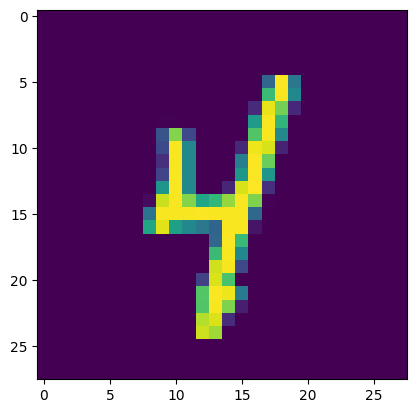

tf.Tensor(4, shape=(), dtype=int64)


In [6]:
for img, label in train:
    print(img.shape)
    plt.imshow(img)
    plt.show()
    print(label)
    break

### Number of unique labels

In [7]:
import tensorflow as tf
from collections import Counter
label_counter = Counter()

for example in train:
    label = example[1].numpy()  # assuming 'label' is a key in the dictionary
    label_counter[label] += 1

print("Label counts:", label_counter)
label = len(label_counter)
print("Number of unique labels:", label)

Label counts: Counter({np.int64(1): 6742, np.int64(7): 6265, np.int64(3): 6131, np.int64(2): 5958, np.int64(9): 5949, np.int64(0): 5923, np.int64(6): 5918, np.int64(8): 5851, np.int64(4): 5842, np.int64(5): 5421})
Number of unique labels: 10


### Pre Processing

In [8]:
def img_preprocessing(dataset):
    X=[]
    Y=[]
    for img, label in dataset:
        X.append(img.numpy())
        Y.append(label.numpy())
    x=np.array(X)/255.0 #Normalization
    y=np.array(Y)
    return x,y

In [9]:
def plot_one_image_per_label(X, Y):
    label_images = {}
    for img, label in zip(X, Y):
        if label not in label_images:
            label_images[label] = img
    plt.figure(figsize=(12, 3))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(np.squeeze(label_images[i])) #np.squeeze() removes extra dimensions if needed.
        plt.xlabel(str(i))
    plt.tight_layout()
    plt.show()

In [10]:
x,y = img_preprocessing(train)
x_test,y_test = img_preprocessing(test)
x_train,x_val,y_train,y_val = train_test_split(x,y, test_size=0.2, random_state=42)

In [11]:
print('All Data: ')
print(x.shape)
print(y.shape)

print("Trainnig Data: ")
print(x_train.shape)
print(y_train.shape)

print('Validation Data: ')
print(x_val.shape)
print(y_val.shape)

print('Test Data')
print(x_test.shape)
print(y_test.shape)

All Data: 
(60000, 28, 28, 1)
(60000,)
Trainnig Data: 
(48000, 28, 28, 1)
(48000,)
Validation Data: 
(12000, 28, 28, 1)
(12000,)
Test Data
(10000, 28, 28, 1)
(10000,)


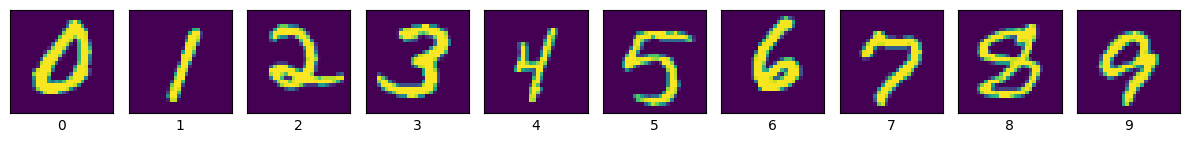

In [12]:
plot_one_image_per_label(x, y)

### Model Layers

In [13]:
model = keras.Sequential([
    Input(shape=(28,28,1,)),
    Conv2D(64, kernel_size=3,strides=2 ,padding='same', activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'),
    MaxPool2D(pool_size=2),
    Flatten(),
    Dense(16, activation='relu',kernel_regularizer=L1(l1=0.001)),
    Dropout(0.2),
    Dense(32, activation='relu',kernel_regularizer=L1(l1=0.001)),
    Dense(label, activation='softmax')   
])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 4, 4, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,042 (86.10 KB)

 Trainable params: 22,042 (86.10 KB)

 Non-trainable params: 0 (0.00 B)

### Compile

In [15]:
o=Adam(learning_rate=0.001)
model.compile(optimizer=o, loss=sparse_categorical_crossentropy, metrics=['accuracy'])

## Fit

In [16]:
# def scheduler(epoch, lr):
#     if epoch < 10:
#         return lr
#     else:
#         return lr * 0.1

In [17]:
History = model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=100,
    validation_data=(x_val, y_val),
    callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)]
)

Epoch 1/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6910 - loss: 1.1045 - val_accuracy: 0.9293 - val_loss: 0.4437
Epoch 2/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8912 - loss: 0.5247 - val_accuracy: 0.9563 - val_loss: 0.3391
Epoch 3/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9171 - loss: 0.4354 - val_accuracy: 0.9580 - val_loss: 0.3078
Epoch 4/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9273 - loss: 0.3923 - val_accuracy: 0.9653 - val_loss: 0.2762
Epoch 5/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9351 - loss: 0.3583 - val_accuracy: 0.9697 - val_loss: 0.2530
Epoch 6/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9405 - loss: 0.3319 - val_accuracy: 0.9715 - val_loss: 0.2349
Epoch 7/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9452 - loss: 0.3117 - val_accuracy: 0.9725 - val_loss: 0.2206
Epoch 8/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9498 - loss: 0.2900 - val_accuracy: 0.

### Plots

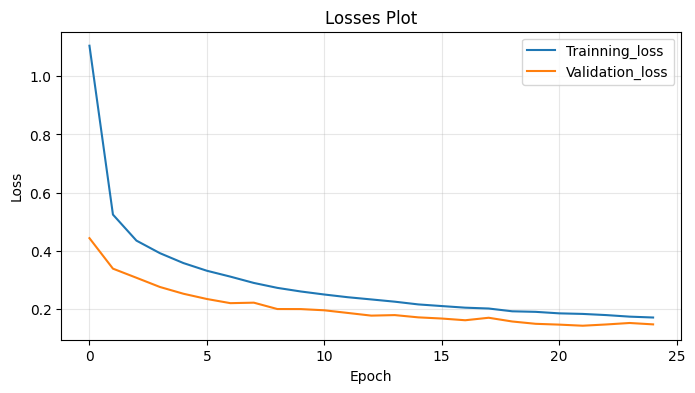

In [18]:
plt.figure(figsize=(8,4))
plt.plot(History.history['loss'], label='Trainning_loss')
plt.plot(History.history['val_loss'], label='Validation_loss')
plt.title("Losses Plot")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

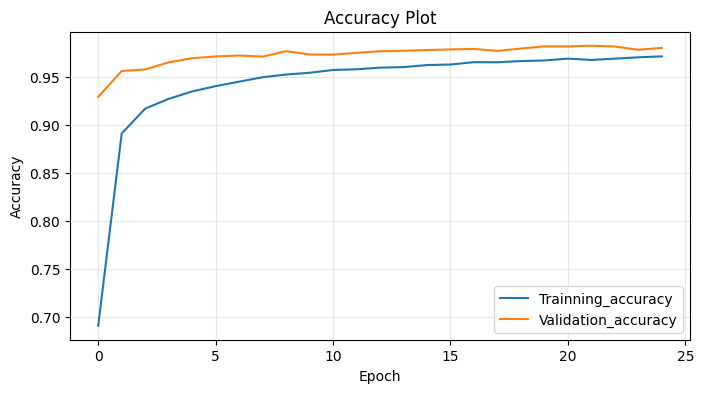

In [19]:
plt.figure(figsize=(8,4))
plt.plot(History.history['accuracy'], label='Trainning_accuracy')
plt.plot(History.history['val_accuracy'], label='Validation_accuracy')
plt.title("Accuracy Plot")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Testing

In [20]:
y_pred = model.predict(x_test)
y_pred_label=np.argmax(y_pred, axis=1)
print(y_pred_label)
print(y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[2 0 4 ... 8 0 5]
[2 0 4 ... 8 0 5]


In [21]:
print(model.evaluate(x_test,y_test))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9845 - loss: 0.1346
[0.13455411791801453, 0.984499990940094]


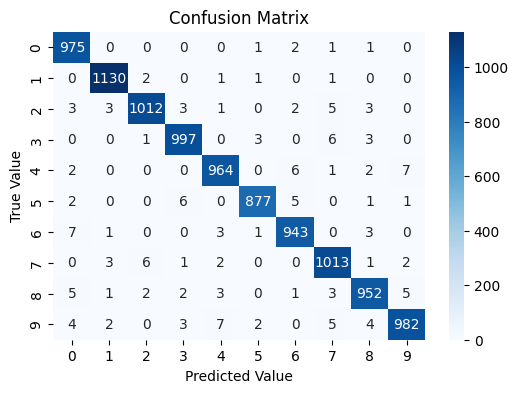

In [22]:
cm = confusion_matrix(y_test,y_pred_label)
plt.figure(figsize=(6,4))
sns.heatmap(cm, cmap='Blues',fmt='d', annot=True)
plt.title("Confusion Matrix")
plt.ylabel('True Value')
plt.xlabel('Predicted Value')
plt.show()

### Checking Random Images

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def show_classified_images(x_test, y_test, y_pred):
    # Find misclassified indices
    misclassified = np.where(y_test == y_pred)[0]

    # Randomly select 10 misclassified samples
    selected = np.random.choice(misclassified, size=10, replace=False)

    # Plot the misclassified images
    fig=plt.figure(figsize=(8, 4))
    for i, idx in enumerate(selected):
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.squeeze(x_test[idx]), cmap='Greens_r')
        plt.title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

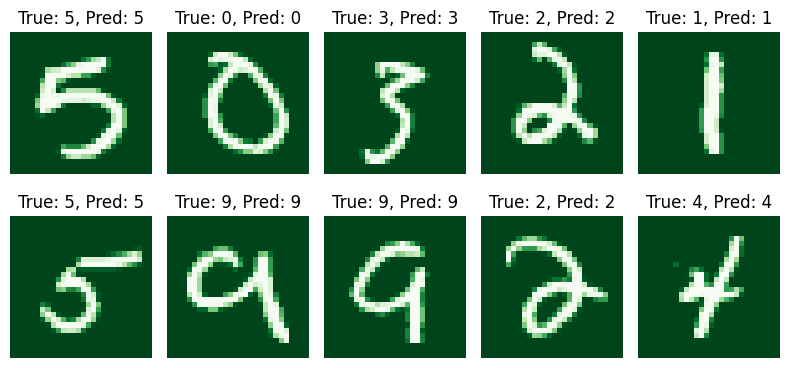

In [24]:
show_classified_images(x_test, y_test, y_pred_label)

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def show_misclassified_images(x_test, y_test, y_pred):
    # Find misclassified indices
    misclassified = np.where(y_test != y_pred)[0]

    # Randomly select 10 misclassified samples
    selected = np.random.choice(misclassified, size=10, replace=False)

    # Plot the misclassified images
    fig=plt.figure(figsize=(8, 4))
    for i, idx in enumerate(selected):
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.squeeze(x_test[idx]), cmap='Reds')
        plt.title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

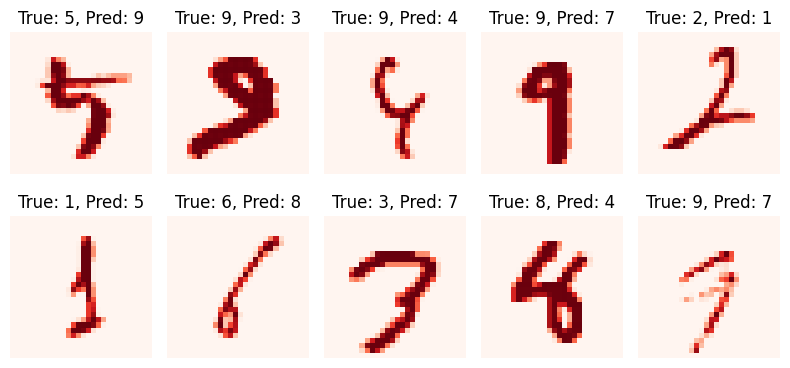

In [26]:
show_misclassified_images(x_test, y_test, y_pred_label)

In [27]:
########################################################## THE END #########################################################